# Hypothesentests zu Erstellungsdaten

## 1. Datenvorbereitung und Bereinigung

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, linregress

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_info_columns', 10000)   # zeigt alle Spaltennamen in info()
pd.set_option('display.max_info_rows', 200000)     # zeigt Zeileninfo, wenn nötig

sns.set_style("whitegrid")

path = Path("dataset/311_Service_Requests_2024.csv")
df = pd.read_csv(path)

## 2. Übersicht des SR_Type Aircraft Noise complaint

In [44]:
aircraft_df = df[df['SR_TYPE'] == 'Aircraft Noise Complaint'].copy()
aircraft_df = aircraft_df[["SR_TYPE", "CREATED_DAY_OF_WEEK", "CREATED_HOUR", "CREATED_MONTH", "CREATED_DATE"]]
aircraft_df.head(10)

,SR_TYPE,CREATED_DAY_OF_WEEK,CREATED_HOUR,CREATED_MONTH,CREATED_DATE
34,Aircraft Noise Complaint,3,23,12,2024-12-31 23:16:56
35,Aircraft Noise Complaint,3,23,12,2024-12-31 23:15:39
63,Aircraft Noise Complaint,3,22,12,2024-12-31 22:54:52
79,Aircraft Noise Complaint,3,22,12,2024-12-31 22:41:28
80,Aircraft Noise Complaint,3,22,12,2024-12-31 22:40:02
84,Aircraft Noise Complaint,3,22,12,2024-12-31 22:35:53
89,Aircraft Noise Complaint,3,22,12,2024-12-31 22:33:43
91,Aircraft Noise Complaint,3,22,12,2024-12-31 22:32:56
98,Aircraft Noise Complaint,3,22,12,2024-12-31 22:29:34
101,Aircraft Noise Complaint,3,22,12,2024-12-31 22:25:12


In [4]:
aircraft_df.nunique()

SR_TYPE                 1
CREATED_DAY_OF_WEEK     7
CREATED_HOUR           24
CREATED_MONTH          12
dtype: int64

## 3. Hypothesentests

**Test 1: Chi²-Test: Erwartete vs. Observierte Verteilung der Beschwerden über die Wochentage**

H0 = Die Beschwerden sind gleichverteilt über die Woche

H1 = Die Beschwerden sind nicht gleichverteilt über die Woche

In [ ]:
# Beobachtete Häufigkeiten (erzwingt Tage 1–7)
observed = aircraft_df["CREATED_DAY_OF_WEEK"].value_counts().reindex(range(1,8), fill_value=0)

# Erwartete Häufigkeiten (Gleichverteilung)
expected = np.full(7, observed.sum() / 7)

# Chi²-Test
chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)

# Effektgröße: Cramér's V
n = observed.sum()
cramers_v = np.sqrt(chi2 / (n * (min(len(observed)-1, 1))))  

# Interpretation
if cramers_v < 0.1:
    effect_label = "vernachlässigbar"
elif cramers_v < 0.3:
    effect_label = "klein"
elif cramers_v < 0.5:
    effect_label = "mittel"
else:
    effect_label = "groß"

print(f"χ² = {chi2:.2f}, df = {len(observed)-1}, p = {p:.4f}")
print(f"Effektgröße: Cramér's V = {cramers_v:.3f} ({effect_label})")

if p < 0.05:
    print("H₀ verwerfen → Aircraft Noise Complaints sind nicht gleichverteilt über die Woche")
else:
    print("H₀ beibehalten → keine Evidenz gegen Gleichverteilung")


χ² = 5779.81, df = 6, p = 0.0000
Effektgröße: Cramér's V = 0.130 (klein)
H₀ verwerfen → Aircraft Noise Complaints sind nicht gleichverteilt über die Woche


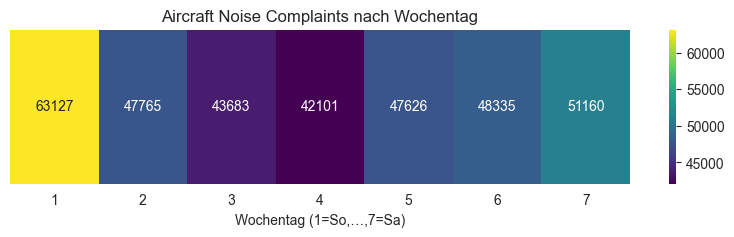

In [22]:
ct = pd.DataFrame(observed).T  

plt.figure(figsize=(10, 2))

sns.heatmap(ct, annot=True, fmt="d", cmap="viridis", cbar=True)

plt.xlabel("Wochentag (1=So,…,7=Sa)")
plt.yticks([], [])   
plt.title("Aircraft Noise Complaints nach Wochentag")
plt.show()

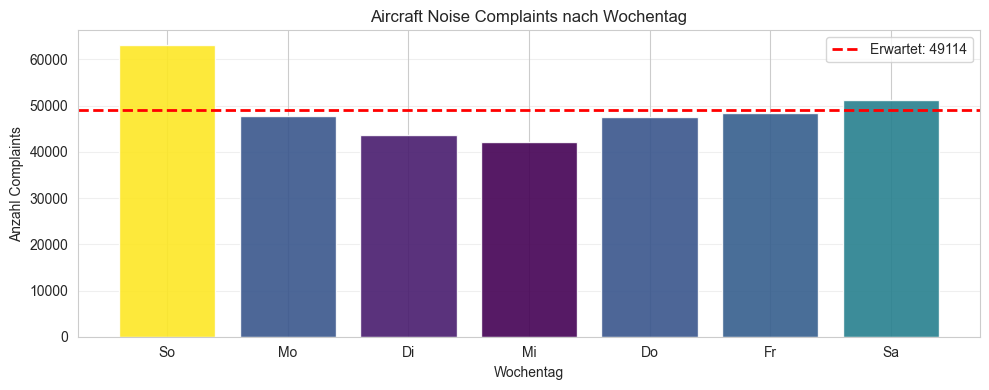

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

days = ["So", "Mo", "Di", "Mi", "Do", "Fr", "Sa"]
x = np.arange(7)

# Farbskala wie in der Heatmap
cmap = sns.color_palette("viridis", as_cmap=True)
norm = plt.Normalize(vmin=observed.min(), vmax=observed.max())
colors = cmap(norm(observed))

plt.figure(figsize=(10, 4))
plt.bar(x, observed, color=colors, alpha=0.9)
plt.axhline(expected.mean(), color="red", linestyle="--", linewidth=2,
            label=f"Erwartet: {expected.mean():.0f}")

plt.xticks(x, days)
plt.xlabel("Wochentag")
plt.ylabel("Anzahl Complaints")
plt.title("Aircraft Noise Complaints nach Wochentag")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


Erkenntnisse: 

Der Chi‑Quadrat‑Test auf Gleichverteilung über die Wochentage ist hochsignifikant (χ² = 5779.81, df = 6, p < 0.001), sodass die Nullhypothese einer gleichmässigen Verteilung der Aircraft Noise Complaints über die Woche verworfen wird. 

Trotz der statistischen Signifikanz ist der Effekt mit Cramér’s V = 0.130 nur klein, das heißt, die Unterschiede zwischen den Wochentagen sind zwar systematisch, aber in der Praxis eher moderat ausgeprägt

**Test 2: Bee Wasp Removal**

H0 = Die Anzahl Bee/Wasp Removal pro Tag ist unter der Woche gleich wie am Wochenende.

H1 = Die Anzahl Bee/Wasp Removal pro Tag ist unterschiedlich am Wochenende oder unter der Woche.


In [25]:
bee_df = df[df['SR_SHORT_CODE'] == 'SGG'].copy()
bee_df = bee_df[["SR_TYPE", "CREATED_DAY_OF_WEEK", "CREATED_HOUR", "CREATED_MONTH"]]
bee_df.head(10)

,SR_TYPE,CREATED_DAY_OF_WEEK,CREATED_HOUR,CREATED_MONTH
2233,Bee/Wasp Removal,3,13,12
7577,Bee/Wasp Removal,2,12,12
10631,Bee/Wasp Removal,1,17,12
17632,Bee/Wasp Removal,6,16,12
17952,Bee/Wasp Removal,6,15,12
19728,Bee/Wasp Removal,6,11,12
24217,Bee/Wasp Removal,5,12,12
25012,Bee/Wasp Removal,5,9,12
25104,Bee/Wasp Removal,5,9,12
29924,Bee/Wasp Removal,3,14,12


In [42]:
# Werktag (Montag–Freitag = 2–6) vs. Wochenende (Sonntag=1, Samstag=7)
counts_weekday = bee_df.loc[bee_df["CREATED_DAY_OF_WEEK"].isin([2,3,4,5,6]), "CREATED_DAY_OF_WEEK"].groupby(bee_df["CREATED_DAY_OF_WEEK"]).count().values
counts_weekend = bee_df.loc[bee_df["CREATED_DAY_OF_WEEK"].isin([1,7]), "CREATED_DAY_OF_WEEK"].groupby(bee_df["CREATED_DAY_OF_WEEK"]).count().values

# t-Test
t_stat, p_value = stats.ttest_ind(counts_weekday, counts_weekend, equal_var=False)

# Cohen's d
sd_pooled = np.sqrt((counts_weekday.std(ddof=1)**2 + counts_weekend.std(ddof=1)**2)/2)
cohens_d = (counts_weekday.mean() - counts_weekend.mean()) / sd_pooled

# Effektgröße
effect = (
    "vernachlässigbar" if abs(cohens_d) < 0.2 else
    "klein" if abs(cohens_d) < 0.5 else
    "mittel" if abs(cohens_d) < 0.8 else
    "groß"
)

# Ausgabe
print(f"t = {t_stat:.3f}, p = {p_value:.4f}, Cohen's d = {cohens_d:.3f}")
print(f"Werktag-Mittel = {counts_weekday.mean():.1f}, Wochenende-Mittel = {counts_weekend.mean():.1f}")
print("Signifikant" if p_value < 0.05 else "Nicht signifikant")
print(f"Effektgröße: {effect}")


t = 4.597, p = 0.0554, Cohen's d = 3.900
Werktag-Mittel = 144.6, Wochenende-Mittel = 88.5
Nicht signifikant
Effektgröße: groß


Erkenntnisse: Der t-Test zu dem Service Request Bee/Wasp Removal ist mit einem zu grossen p-Wert nicht sifnifikant. 

**TEST 3: Garbage Removal – Winter vs. Sommer (Requests pro Tag)**

H₀: Die durchschnittliche Anzahl Garbage-Requests pro Tag ist 
    im Winter gleich wie im Sommer.

H₁: Die durchschnittliche Anzahl unterscheidet sich.

In [33]:
garbage_df = df[df['SR_TYPE'].str.contains('Missed Garbage', case=False, na=False)].copy()
garbage_df = garbage_df[["SR_TYPE", "CREATED_DAY_OF_WEEK", "CREATED_HOUR", "CREATED_MONTH"]]

garbage_df.head(10)

,SR_TYPE,CREATED_DAY_OF_WEEK,CREATED_HOUR,CREATED_MONTH
83,Missed Garbage Pick-Up Complaint,3,22,12
460,Missed Garbage Pick-Up Complaint,3,19,12
573,Missed Garbage Pick-Up Complaint,3,19,12
667,Missed Garbage Pick-Up Complaint,3,18,12
683,Missed Garbage Pick-Up Complaint,3,18,12
888,Missed Garbage Pick-Up Complaint,3,17,12
895,Missed Garbage Pick-Up Complaint,3,17,12
914,Missed Garbage Pick-Up Complaint,3,17,12
986,Missed Garbage Pick-Up Complaint,3,17,12
999,Missed Garbage Pick-Up Complaint,3,17,12


In [34]:
garbage_df.nunique()

SR_TYPE                 1
CREATED_DAY_OF_WEEK     7
CREATED_HOUR           24
CREATED_MONTH          12
dtype: int64

In [ ]:
# Winter und Sommer definieren
winter_df = garbage_df[garbage_df['CREATED_MONTH'].isin([12,1,2])]
sommer_df = garbage_df[garbage_df['CREATED_MONTH'].isin([6,7,8])]

# Tagesweise aggregieren: Anzahl Requests pro Tag
winter_counts = winter_df.groupby(winter_df.index).size().values
sommer_counts = sommer_df.groupby(sommer_df.index).size().values

# Prüfen, ob Standardabweichung > 0
if np.std(winter_counts) == 0 or np.std(sommer_counts) == 0:
    print("Varianz zu klein, t-Test nicht möglich")
else:
    # t-Test
    t_stat, p_value = stats.ttest_ind(winter_counts, sommer_counts, equal_var=False)

    # Cohen's d
    sd_pooled = np.sqrt((winter_counts.std(ddof=1)**2 + sommer_counts.std(ddof=1)**2)/2)
    cohens_d = (winter_counts.mean() - sommer_counts.mean()) / sd_pooled

    print(f"t = {t_stat:.3f}, p = {p_value:.4f}, Cohen's d = {cohens_d:.3f}")

Varianz zu klein, t-Test nicht möglich


Da wir nur bei dem SR Type Aircraft Noise Complaint einen signifikanten Unterschied in der Verteilung gesehen haben, fahren wir mit diesem SR Type vor. 

Wir prüfen jetzt nicht nur auf den CREATED_DAY_OF_WEEK sondern jetzt auch auf CREATED_MONTH und CREATED_HOUR

**TEST 4: Aircraft Noise – Geschäftszeiten vs. Nach**

H₀: Die durchschnittliche Anzahl Aircraft Noise Complaints pro Stunde ist tagsüber (8-18 Uhr) gleich wie nachts (22-6 Uhr).

H₁: Die durchschnittliche Anzahl unterscheidet sich.

In [45]:
# Sicherstellen, dass CREATED_DATE als datetime vorliegt
aircraft_df['CREATED_DATE'] = pd.to_datetime(aircraft_df['CREATED_DATE'])

# Tag/Nacht-Spalte
aircraft_df['TagNacht'] = np.where(
    aircraft_df['CREATED_HOUR'].between(8,18), 'Tag',
    np.where(aircraft_df['CREATED_HOUR'].isin(list(range(22,24)) + list(range(0,7))), 'Nacht', 'Sonstige')
)

# Nur Tag/Nacht behalten
daily_counts = (
    aircraft_df[aircraft_df['TagNacht'] != 'Sonstige']
    .groupby([aircraft_df['CREATED_DATE'].dt.date, 'TagNacht'])
    .size()
    .reset_index(name='count')
)

# Arrays für t-Test
tag_counts = daily_counts.loc[daily_counts['TagNacht']=='Tag', 'count'].values
nacht_counts = daily_counts.loc[daily_counts['TagNacht']=='Nacht', 'count'].values

# Welch-t-Test
t_stat, p_value = stats.ttest_ind(tag_counts, nacht_counts, equal_var=False)

# Cohen's d
sd_pooled = np.sqrt((tag_counts.std(ddof=1)**2 + nacht_counts.std(ddof=1)**2)/2)
cohens_d = (nacht_counts.mean() - tag_counts.mean()) / sd_pooled

print(f"t = {t_stat:.3f}, p = {p_value:.4f}, Cohen's d = {cohens_d:.3f}")


t = 44.389, p = 0.0000, Cohen's d = -3.281


C:\Users\katha\AppData\Local\Temp\ipykernel_2828\1757268542.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax1.boxplot([tag_counts, nacht_counts], labels=['Tag (8-18h)', 'Nacht (22-6h)'], patch_artist=True,


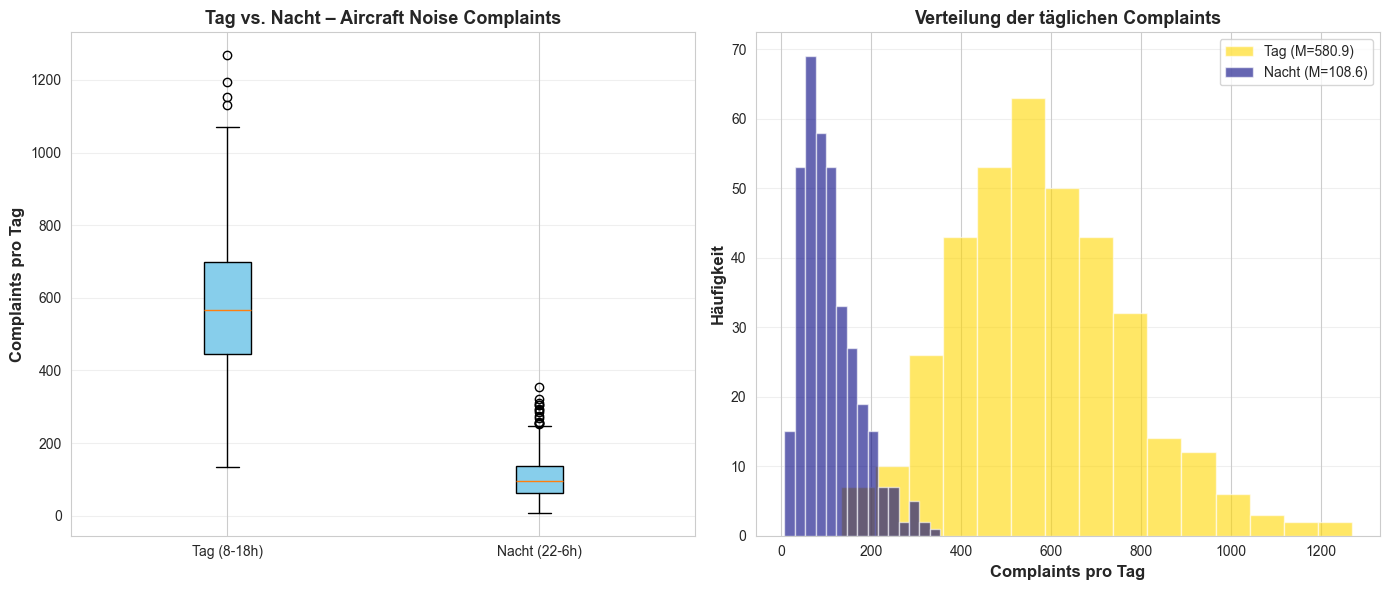

In [47]:
# Visualisierung
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot
ax1.boxplot([tag_counts, nacht_counts], labels=['Tag (8-18h)', 'Nacht (22-6h)'], patch_artist=True,
            boxprops=dict(facecolor='skyblue'))
ax1.set_ylabel('Complaints pro Tag', fontsize=12, fontweight='bold')
ax1.set_title(f'Tag vs. Nacht – Aircraft Noise Complaints', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Histogramme
ax2.hist(tag_counts, alpha=0.6, bins=15, label=f'Tag (M={tag_counts.mean():.1f})', color='gold')
ax2.hist(nacht_counts, alpha=0.6, bins=15, label=f'Nacht (M={nacht_counts.mean():.1f})', color='navy')
ax2.set_xlabel('Complaints pro Tag', fontsize=12, fontweight='bold')
ax2.set_ylabel('Häufigkeit', fontsize=12, fontweight='bold')
ax2.set_title("Verteilung der täglichen Complaints", fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

TEST 5: Aircraft Noise – Gleichverteilung über 12 Monate?
H₀: Aircraft Noise Complaints sind gleichverteilt über alle 12 Monate (jeder Monat hat P = 1/12 ≈ 8.33%)

H₁: Mindestens ein Monat weicht von der Gleichverteilung ab (es gibt saisonale Unterschiede)

In [ ]:
# Monatsnamen
month_names_full = ['Jan','Feb','Mär','Apr','Mai','Jun','Jul','Aug','Sep','Okt','Nov','Dez']

# Beobachtete Häufigkeiten pro Monat
observed = aircraft_df['CREATED_MONTH'].value_counts().reindex(range(1,13), fill_value=0)

# Erwartete Häufigkeiten bei Gleichverteilung
expected = np.full(12, observed.sum() / 12)

# Chi²-Test
chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)

# Effektgröße: Cramér's V
n = observed.sum()
cramers_v = np.sqrt(chi2 / (n * (len(observed)-1)))

# Effektgröße interpretieren
if cramers_v < 0.1:
    effect_label = "vernachlässigbar"
elif cramers_v < 0.3:
    effect_label = "klein"
elif cramers_v < 0.5:
    effect_label = "mittel"
else:
    effect_label = "groß"

# Ausgabe
print(f"χ² = {chi2:.2f}, df = {len(observed)-1}, p = {p:.4f}")
print(f"Effektgröße: Cramér's V = {cramers_v:.3f} ({effect_label})")
if p < 0.05:
    print("H₀ verwerfen → Aircraft Noise Complaints sind nicht gleichverteilt über die Monate")
else:
    print("H₀ beibehalten → keine Evidenz gegen Gleichverteilung")

χ² = 7514.60, df = 11, p = 0.0000
Effektgröße: Cramér's V = 0.045 (vernachlässigbar)
H₀ verwerfen → Aircraft Noise Complaints sind nicht gleichverteilt über die Monate


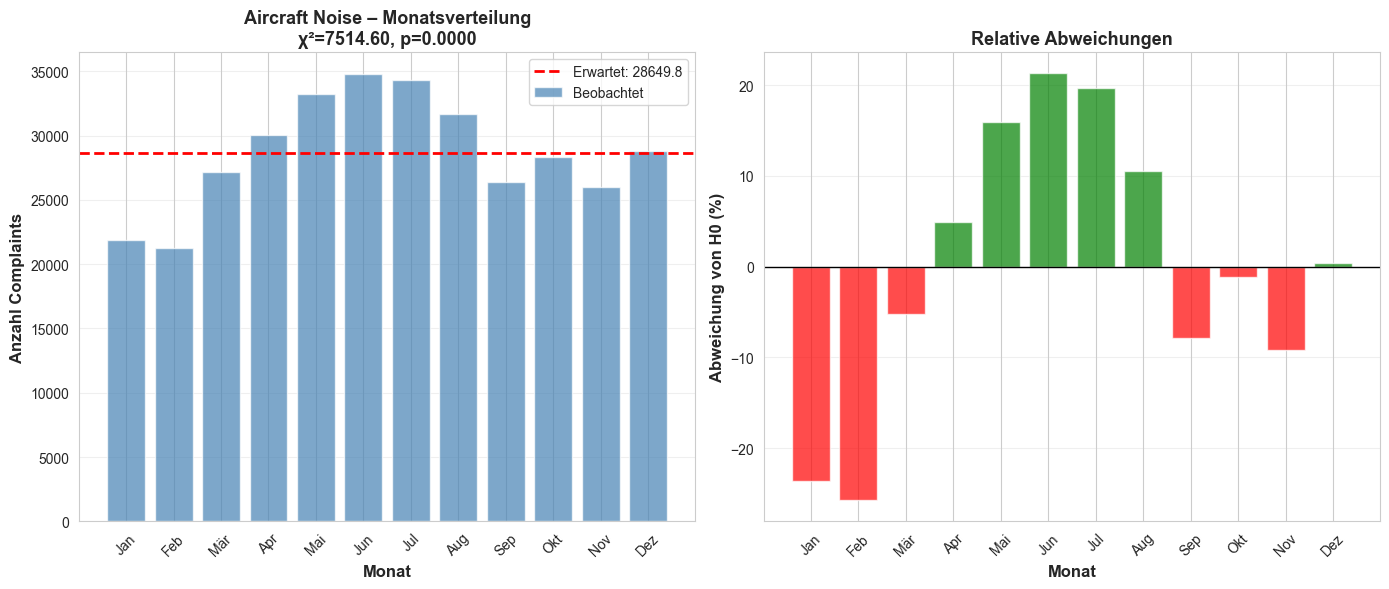

In [49]:
# Visualisierung: Beobachtet vs. Erwartet + Abweichungen
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

# Balkendiagramm: Beobachtet vs. Erwartet
x = np.arange(12)
ax1.bar(x, observed, alpha=0.7, color='steelblue', label='Beobachtet')
ax1.axhline(expected[0], color='red', linestyle='--', linewidth=2, label=f'Erwartet: {expected[0]:.1f}')
ax1.set_xticks(x)
ax1.set_xticklabels(month_names_full, rotation=45)
ax1.set_xlabel('Monat', fontsize=12, fontweight='bold')
ax1.set_ylabel('Anzahl Complaints', fontsize=12, fontweight='bold')
ax1.set_title(f'Aircraft Noise – Monatsverteilung\nχ²={chi2:.2f}, p={p:.4f}', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Abweichungen in Prozent
deviations = (observed - expected) / expected * 100
colors = ['green' if d > 0 else 'red' for d in deviations]
ax2.bar(x, deviations, color=colors, alpha=0.7)
ax2.axhline(0, color='black', linewidth=1)
ax2.set_xticks(x)
ax2.set_xticklabels(month_names_full, rotation=45)
ax2.set_xlabel('Monat', fontsize=12, fontweight='bold')
ax2.set_ylabel('Abweichung von H0 (%)', fontsize=12, fontweight='bold')
ax2.set_title('Relative Abweichungen', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


Wir sehen einen signifikanten Unterschied zwischen den Monaten. 

Jetzt versuchen wir herauszufinden, warum in manchen Monaten mehr Noise Complaints als in anderen eintreffen. 

Dazu nehmen wir das Bureau of Transportation von den USA (Link: https://www.transtats.bts.gov/Data_Elements.aspx?Data=1) Dieser listet alle Flüge die von den Flughäfen aus losfliegen nach Monaten sortiert. 

In diesem haben wir nach den zwei Flughäfen in Chicago: O'Hare und Midway gesucht. Jetzt wollen wir testen, ob die Noise Complaints im Sommer mehr werden, weil mehr Flüge von den Flughäfen fliegen. 

Wir testen Korrelation zwischen Flugverkehr und Complaints.

Hypothesen:


H₀: ρ = 0
    Es gibt KEINE Korrelation zwischen Flugverkehr und Aircraft Noise Complaints.

H₁: ρ ≠ 0
    Es gibt eine lineare Korrelation (mehr Flüge → mehr Complaints).


In [ ]:
# Flights pro Monat (BTS)
flight_data = pd.DataFrame({
    'Month': range(1, 13),
    'Midway': [590014, 627530, 882598, 858001, 956406, 1053740, 
               1111353, 971474, 907104, 886733, 758648, 783065],
    'OHare': [2399064, 2520741, 3105192, 3059133, 3503239, 3600837,
              3645813, 3660310, 3399832, 3480444, 3013263, 3232061]
})
flight_data['Total_Flights'] = flight_data['Midway'] + flight_data['OHare']

# Complaints pro Monat direkt aus aircraft_df
complaints_by_month = aircraft_df['CREATED_MONTH'].value_counts().sort_index()

# Kombiniertes DataFrame
df_combined = pd.DataFrame({
    'Month': range(1,13),
    'Complaints': complaints_by_month.reindex(range(1,13), fill_value=0).values,
    'Flights': flight_data['Total_Flights'].values
})

month_names_full = ['Jan','Feb','Mär','Apr','Mai','Jun','Jul','Aug','Sep','Okt','Nov','Dez']

# Pearson-Korrelation
r, p_corr = pearsonr(df_combined['Flights'], df_combined['Complaints'])

# Lineare Regression
slope, intercept, r_value, p_reg, std_err = linregress(df_combined['Flights'], df_combined['Complaints'])

# Stärke der Korrelation interpretieren
if abs(r) < 0.3:
    strength = "schwach"
elif abs(r) < 0.7:
    strength = "mittel"
else:
    strength = "stark"

# Ausgabe
print(f"Pearson-Korrelation: r = {r:.3f}, p = {p_corr:.4f}, Stärke: {strength}")
print(f"Lineare Regression: y = {slope:.4f}x + {intercept:.1f}, R² = {r_value**2:.3f}, p = {p_reg:.4f}")

if p_corr < 0.05:
    print("→ Statistisch signifikanter Zusammenhang zwischen Flügen und Complaints")
else:
    print("→ Keine statistisch signifikante Korrelation")

print(f"Varianzaufklärung: {r_value**2*100:.1f}% der Schwankungen in Complaints erklärt durch Flugbewegungen")


Pearson-Korrelation: r = 0.905, p = 0.0001, Stärke: stark
Lineare Regression: y = 0.0070x + -77.5, R² = 0.819, p = 0.0001
→ Statistisch signifikanter Zusammenhang zwischen Flügen und Complaints
Varianzaufklärung: 81.9% der Schwankungen in Complaints erklärt durch Flugbewegungen


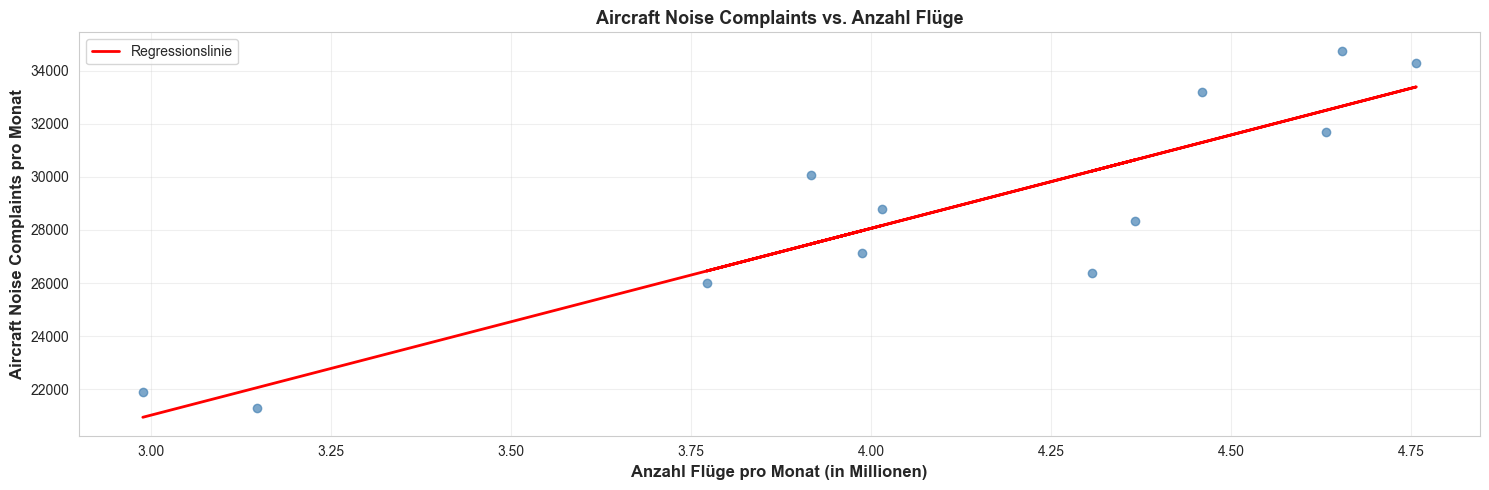

In [59]:
#Visualierung
plt.figure(figsize=(15,5))

# Scatterplot
plt.scatter(df_combined['Flights']/1e6, df_combined['Complaints'], color='steelblue', alpha=0.7)

# Regressionslinie
plt.plot(df_combined['Flights']/1e6, intercept + slope*df_combined['Flights'], color='red', linewidth=2, label='Regressionslinie')

# Achsenbeschriftungen
plt.xlabel('Anzahl Flüge pro Monat (in Millionen)', fontsize=12, fontweight='bold')
plt.ylabel('Aircraft Noise Complaints pro Monat', fontsize=12, fontweight='bold')
plt.title('Aircraft Noise Complaints vs. Anzahl Flüge', fontsize=13, fontweight='bold')

plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
# Erstelle Monatsnummer
df_combined['Month_Num'] = range(1, len(df_combined) + 1)

# PARTIELLE KORRELATION (Sommer-Effekt entfernen)
# Schritt 1: Residuen von Flights nach Kontrolle für Month_Num
slope1, intercept1, _, _, _ = linregress(df_combined['Month_Num'], df_combined['Flights'])
residuals_flights = df_combined['Flights'] - (intercept1 + slope1 * df_combined['Month_Num'])

# Schritt 2: Residuen von Complaints nach Kontrolle für Month_Num
slope2, intercept2, _, _, _ = linregress(df_combined['Month_Num'], df_combined['Complaints'])
residuals_complaints = df_combined['Complaints'] - (intercept2 + slope2 * df_combined['Month_Num'])

# Schritt 3: Korrelation der Residuen = partielle Korrelation
partial_corr, partial_p = pearsonr(residuals_flights, residuals_complaints)

print(f"\n KAUSALITÄTSTEST: Sommer-Scheinkorrelation?")
print(f"=" * 55)
print(f"Ursprüngliche Korrelation:        r = {r:.3f}, p = {p_corr:.4f}")
print(f"Nach Kontrolle für Saisonalität:  r = {partial_corr:.3f}, p = {partial_p:.4f}")
print(f"\nÄnderung: {abs(r - partial_corr):.3f}")

if abs(partial_corr) > 0.5 and partial_p < 0.05:
    print("\n ERGEBNIS: Starke Korrelation bleibt bestehen!")
    print("   → Flüge verursachen direkt Beschwerden (kausaler Zusammenhang)")
else:
    print("\n ERGEBNIS: Korrelation wird schwach!")
    print("   → War vermutlich Scheinkorrelation durch Saisonalität")


 KAUSALITÄTSTEST: Sommer-Scheinkorrelation?
Ursprüngliche Korrelation:        r = 0.905, p = 0.0001
Nach Kontrolle für Saisonalität:  r = 0.913, p = 0.0000

Änderung: 0.008

 ERGEBNIS: Starke Korrelation bleibt bestehen!
   → Flüge verursachen direkt Beschwerden (kausaler Zusammenhang)


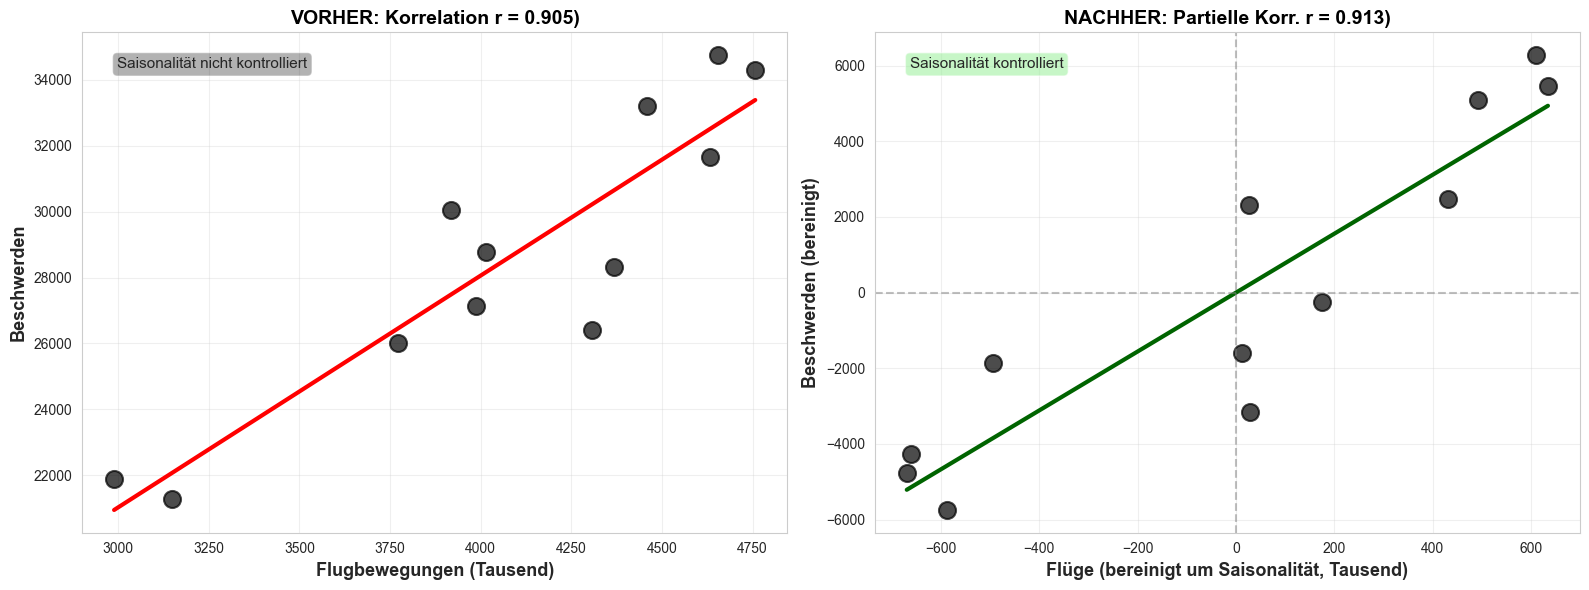

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PLOT 1: Ursprüngliche Korrelation
ax1 = axes[0]
ax1.scatter(df_combined['Flights'] / 1000, df_combined['Complaints'], 
           s=150, alpha=0.7, color='black', edgecolors='black', linewidth=1.5)
x_pred = np.linspace(df_combined['Flights'].min(), df_combined['Flights'].max(), 100)
y_pred = intercept + slope * x_pred
ax1.plot(x_pred / 1000, y_pred, color='red', linewidth=3)
ax1.set_xlabel('Flugbewegungen (Tausend)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Beschwerden', fontsize=13, fontweight='bold')
ax1.set_title(f'VORHER: Korrelation r = {r:.3f})', 
             fontsize=14, fontweight='bold', color='black')
ax1.grid(alpha=0.3)
ax1.text(0.05, 0.95, 'Saisonalität nicht kontrolliert', 
         transform=ax1.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='black', alpha=0.3))

# PLOT 2: Nach Saisonalitäts-Kontrolle
ax2 = axes[1]
ax2.scatter(residuals_flights / 1000, residuals_complaints, 
           s=150, alpha=0.7, color='black', edgecolors='black', linewidth=1.5)
slope_res, intercept_res, _, _, _ = linregress(residuals_flights, residuals_complaints)
x_res = np.linspace(residuals_flights.min(), residuals_flights.max(), 100)
y_res = intercept_res + slope_res * x_res
ax2.plot(x_res / 1000, y_res, color='darkgreen', linewidth=3)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax2.axvline(0, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Flüge (bereinigt um Saisonalität, Tausend)', fontsize=13, fontweight='bold')
ax2.set_ylabel('Beschwerden (bereinigt)', fontsize=13, fontweight='bold')
ax2.set_title(f'NACHHER: Partielle Korr. r = {partial_corr:.3f})', 
             fontsize=14, fontweight='bold', color='black')
ax2.grid(alpha=0.3)
ax2.text(0.05, 0.95, 'Saisonalität kontrolliert', 
         transform=ax2.transAxes, fontsize=11, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()


Mit der Trichterform im Residuenplot erkennen wir Heteroskedaszität. Das heisst wir können keine genauen Vorhersagen mit der Regression treffen. Für die Hauptaussage: Die Anzahl Aircraft Noise Complaints korreliert mit der Anzahl Flüge ist dies aber kein Problem. 

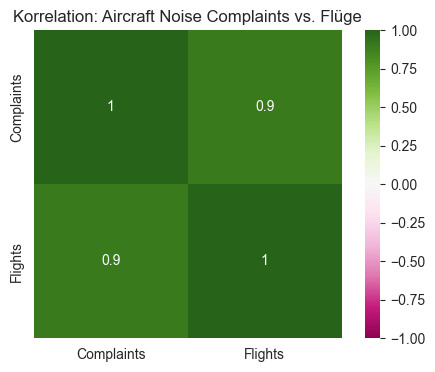

In [63]:
# DataFrame nur mit den beiden relevanten Spalten
corr_data = df_combined[['Complaints', 'Flights']]

# Korrelationsmatrix
corr_matrix = corr_data.corr()

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='PiYG',
    vmin=-1,
    vmax=1,
    square=True
)
plt.title("Korrelation: Aircraft Noise Complaints vs. Flüge")
plt.show()


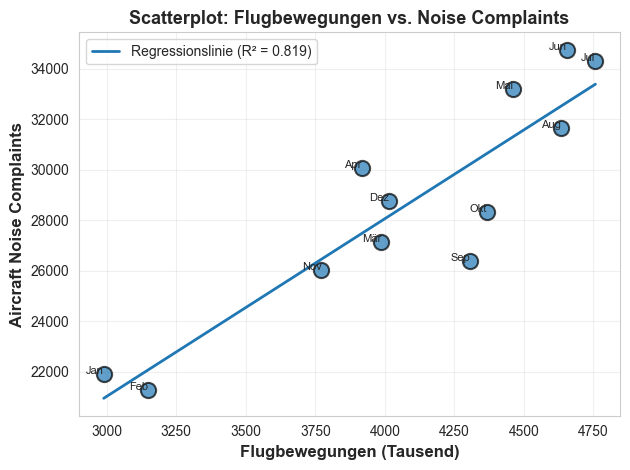

In [64]:
plt.scatter(
    df_combined['Flights'] / 1000,
    df_combined['Complaints'],
    s=120, alpha=0.7,
    edgecolors='black', linewidth=1.5
)

# Regressionslinie
x_vals = np.linspace(
    df_combined['Flights'].min(),
    df_combined['Flights'].max(),
    200
)
y_vals = intercept + slope * x_vals

plt.plot(
    x_vals / 1000,
    y_vals,
    linewidth=2,
    label=f"Regressionslinie (R² = {r_value**2:.3f})"
)

# Monatsnamen einzeichnen
for i, month in enumerate(month_names_full):
    plt.annotate(
        month,
        (df_combined['Flights'].iloc[i] / 1000,
         df_combined['Complaints'].iloc[i]),
        fontsize=8,
        ha='right'
    )

# Achsentitel & Formatierung
plt.xlabel("Flugbewegungen (Tausend)", fontsize=12, fontweight='bold')
plt.ylabel("Aircraft Noise Complaints", fontsize=12, fontweight='bold')
plt.title("Scatterplot: Flugbewegungen vs. Noise Complaints", fontsize=13, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()